# Classificação Multi-label de Gêneros de Filmes baseado em Sinopses

Este notebook apresenta uma solução para o desafio de classificação multi-label dos gêneros de filmes com base nas sinopses do CMU Movie Summary Corpus.

### 1. Configuração do Ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, f1_score
from sklearn.pipeline import Pipeline
import pickle
import warnings
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danilo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danilo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Danilo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. Carregamento e Exploração dos Dados

In [2]:
def load_movie_metadata():
    columns = ['wiki_movie_id', 'freebase_movie_id', 'movie_name', 'release_date', 
               'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
    
    movie_metadata = pd.read_csv('../data/raw/movie.metadata.tsv', sep='\t', header=None, names=columns)
    return movie_metadata

def load_plot_summaries():
    plot_summaries = pd.read_csv('../data/raw/plot_summaries.txt', sep='\t', header=None, names=['wiki_movie_id', 'plot_summary'])
    return plot_summaries

movie_metadata = load_movie_metadata()
plot_summaries = load_plot_summaries()

#### 2.1 Explorando os Metadados dos Filmes


In [3]:
movie_metadata.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wiki_movie_id       81741 non-null  int64  
 1   freebase_movie_id   81741 non-null  object 
 2   movie_name          81741 non-null  object 
 3   release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   runtime             61291 non-null  float64
 6   languages           81741 non-null  object 
 7   countries           81741 non-null  object 
 8   genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [5]:
print(plot_summaries.isnull().sum())

wiki_movie_id    0
plot_summary     0
dtype: int64


In [6]:
sample_genres = movie_metadata['genres'].head(10).tolist()
print("Formatos de gêneros:\n")
for i, genres in enumerate(sample_genres, 1):
    print(f"{i}. {genres}")

Formatos de gêneros:

1. {"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}
2. {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biographical film", "/m/07s9rl0": "Drama", "/m/0hj3n01": "Crime Drama"}
3. {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "Drama"}
4. {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic thriller", "/m/09blyk": "Psychological thriller"}
5. {"/m/07s9rl0": "Drama"}
6. {"/m/02hmvc": "Short Film", "/m/06ppq": "Silent film", "/m/0219x_": "Indie", "/m/01g6gs": "Black-and-white", "/m/01z4y": "Comedy"}
7. {"/m/0hqxf": "Family Film", "/m/01hmnh": "Fantasy", "/m/03k9fj": "Adventure", "/m/03q4nz": "World cinema"}
8. {"/m/04t36": "Musical", "/m/01z4y": "Comedy", "/m/01g6gs": "Black-and-white"}
9. {"/m/04t36": "Musical", "/m/07s9rl0": "Drama", "/m/01z4y": "Comedy"}
10. {"/m/03npn": "Horror", "/m/0fdjb": "Supernatural"}


#### 2.2 Explorando Sinopses

In [7]:
plot_summaries.head()

,wiki_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [8]:
plot_summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   wiki_movie_id  42303 non-null  int64 
 1   plot_summary   42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [9]:
print(plot_summaries.isnull().sum())

wiki_movie_id    0
plot_summary     0
dtype: int64


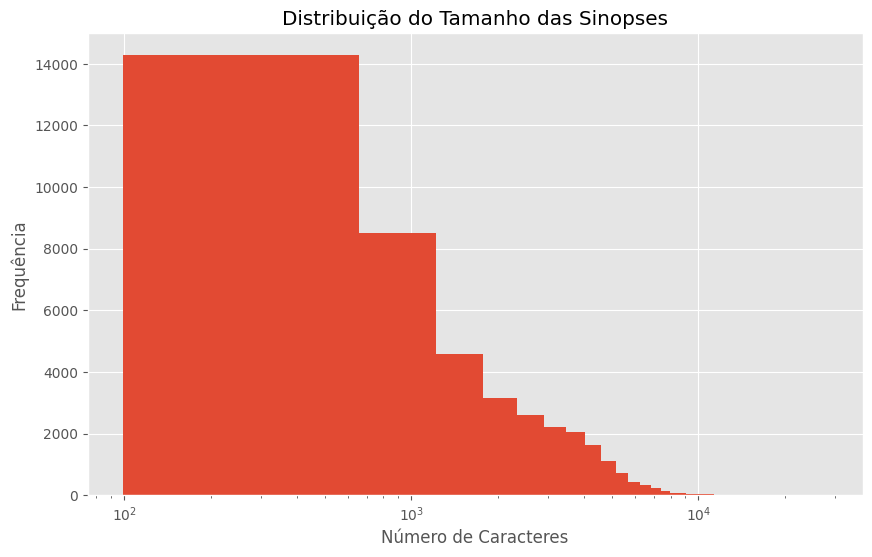

Tamanho médio das sinopses: 1784.03 caracteres
Tamanho mediano das sinopses: 1079.00 caracteres
Sinopse mais curta: 99 caracteres
Sinopse mais longa: 28159 caracteres


In [10]:
plot_summaries['summary_length'] = plot_summaries['plot_summary'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(plot_summaries['summary_length'], bins=50)
plt.title('Distribuição do Tamanho das Sinopses')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')
plt.xscale('log')
plt.show()

print(f"Tamanho médio das sinopses: {plot_summaries['summary_length'].mean():.2f} caracteres")
print(f"Tamanho mediano das sinopses: {plot_summaries['summary_length'].median():.2f} caracteres")
print(f"Sinopse mais curta: {plot_summaries['summary_length'].min()} caracteres")
print(f"Sinopse mais longa: {plot_summaries['summary_length'].max()} caracteres")

### 3. Pré-processamento dos Dados

#### 3.1 Unindo os Datasets e Tratando os Gêneros

In [11]:
movies_df = pd.merge(movie_metadata, plot_summaries, on='wiki_movie_id', how='inner')
print(f"Número de filmes: {movies_df.shape[0]}")

Número de filmes: 42204


In [12]:
# Extração de gêneros de string para lista
def extract_genres(genres_str):
    if pd.isna(genres_str):
        return []
    try:
        # Formato esperado: '/m/01jfsb:Thriller'
        genre_list = []
        for genre_pair in genres_str.split(','):
            if ':' in genre_pair:
                genre = genre_pair.split(':')[1].strip()
                genre_list.append(genre)
        return genre_list
    except Exception as e:
        print(f"Erro ao processar: {genres_str}")
        print(e)
        return []

In [13]:
movies_df['genres_list'] = movies_df['genres'].apply(extract_genres)

In [14]:
# Gêneros mais comuns
all_genres = [genre for sublist in movies_df['genres_list'] for genre in sublist]
genre_counts = Counter(all_genres)

In [15]:
# Agrupar gêneros raros em Outros
min_genre_count = 100
rare_genres = {genre for genre, count in genre_counts.items() if count < min_genre_count}
movies_df['genres_list'] = movies_df['genres_list'].apply(
    lambda x: ['Outros' if g in rare_genres else g for g in x]
)

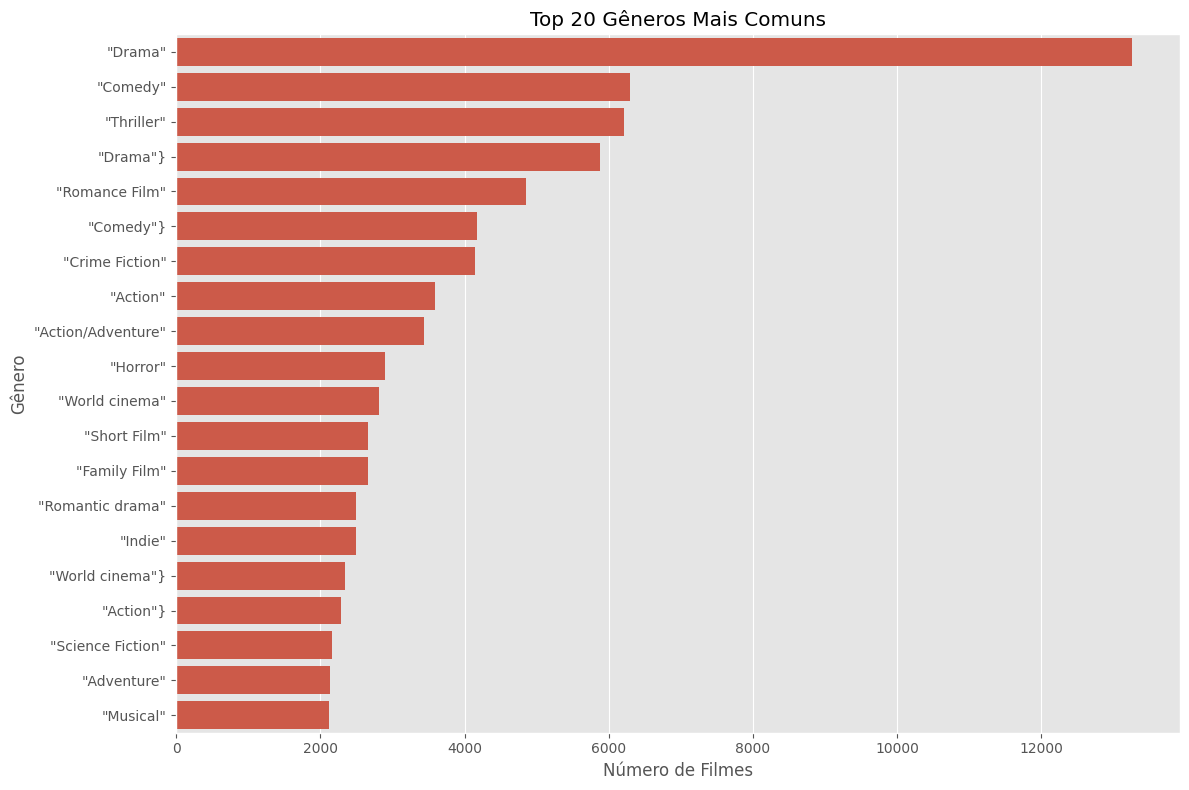

In [16]:
plt.figure(figsize=(12, 8))
genre_df = pd.DataFrame({'genre': list(genre_counts.keys()), 'count': list(genre_counts.values())})
genre_df = genre_df.sort_values('count', ascending=False).head(20)
sns.barplot(x='count', y='genre', data=genre_df)
plt.title('Top 20 Gêneros Mais Comuns')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.tight_layout()
plt.show()

#### 3.2 Filtrando e Limpando os Dados


In [17]:
# Removendo filmes sem gêneros
movies_df = movies_df[movies_df['genres_list'].map(len) > 0]
movies_df.shape[0]

41793

In [18]:
# Inclusão apenas de gêneros com mais de 100 ou outras ocorrências
min_genre_count = 100
valid_genres = [genre for genre, count in genre_counts.items() if count >= min_genre_count]
valid_genres.append('Outros') 
print(f"Número de gêneros válidos: {len(valid_genres)}")

Número de gêneros válidos: 161


In [19]:
# Filtrando as listas de gêneros para incluir apenas gêneros válidos
movies_df['filtered_genres'] = movies_df['genres_list'].apply(lambda x: [g for g in x if g in valid_genres])

In [20]:
# Removendo filmes que não têm gêneros válidos após o filtro
movies_df = movies_df[movies_df['filtered_genres'].map(len) > 0]
movies_df.shape[0]

41793

In [21]:
# Filtrar sinopses por comprimento
min_length = 200  
max_length = 4000 
movies_df = movies_df[movies_df['summary_length'].between(min_length, max_length)]
print(f"Número de filmes após filtrar por comprimento de sinopse: {movies_df.shape[0]}")

Número de filmes após filtrar por comprimento de sinopse: 34668


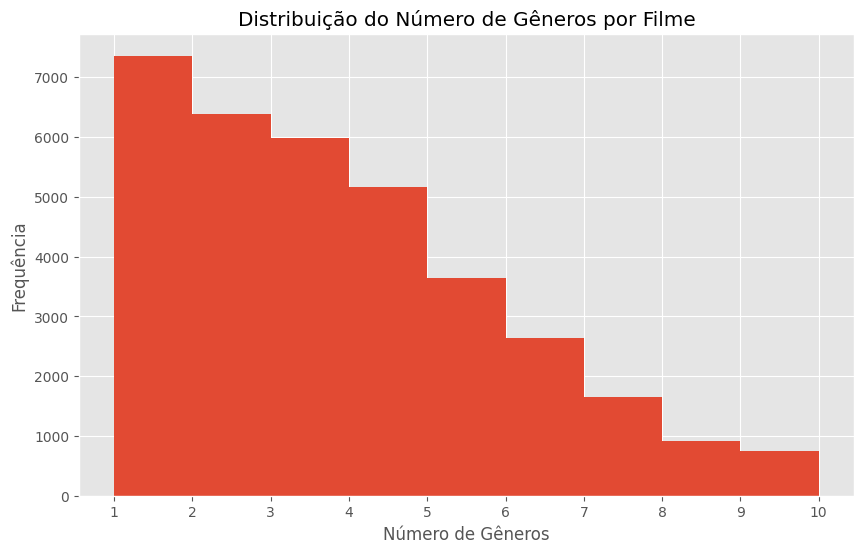

num_genres
1     7361
2     6381
3     5987
4     5172
5     3638
6     2636
7     1651
8      912
9      514
10     240
11     107
12      39
13      20
14       6
15       3
16       1
Name: count, dtype: int64


In [22]:
# Distribuição de número de gêneros por filme
movies_df['num_genres'] = movies_df['filtered_genres'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(movies_df['num_genres'], bins=range(1, 11))
plt.title('Distribuição do Número de Gêneros por Filme')
plt.xlabel('Número de Gêneros')
plt.ylabel('Frequência')
plt.xticks(range(1, 11))
plt.show()

print(movies_df['num_genres'].value_counts().sort_index())

#### 3.3 Pré-processamento das Sinopses

In [23]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    
    doc = nlp(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [25]:
# Aplicando as sinopses
movies_df['processed_summary'] = movies_df['plot_summary'].apply(preprocess_text)

In [26]:
# Identificar palavras raras (mantendo a lógica anterior)
all_tokens = ' '.join(movies_df['processed_summary']).split()
token_counts = Counter(all_tokens)
min_token_freq = 5
frequent_tokens = {token for token, count in token_counts.items() if count >= min_token_freq}

In [27]:
def filter_rare_words(text):
    return ' '.join([word for word in text.split() if word in frequent_tokens])

movies_df['processed_summary'] = movies_df['processed_summary'].apply(filter_rare_words)

In [28]:
for i, (original, processed) in enumerate(zip(movies_df['plot_summary'].head(3), movies_df['processed_summary'].head(3))):
    print(f"\nExemplo {i+1}:")
    print(f"Original (primeiros 200 caracteres): {original[:200]}...")
    print(f"Processado (primeiros 200 caracteres): {processed[:200]}...")


Exemplo 1:
Original (primeiros 200 caracteres): Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society ...
Processado (primeiros 200 caracteres): set second half nd century film depict mar planet terraforme allow human walk surface without wear pressure suit martian society become largely woman position authority story concern police officer me...

Exemplo 2:
Original (primeiros 200 caracteres): A series of murders of rich young women throughout Arizona bear distinctive signatures of a serial killer. Clues lead Detective Charles Mendoza to visit Paul White, a sound expert installing hi-fi sys...
Processado (primeiros 200 caracteres): series murder rich young woman throughout arizona bear distinctive signature serial killer clue lead detective charles mendoza visit paul white sound expert instal hifi system wealthy people home spec...

Exemplo

In [29]:
# Inclusão da década como feature
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year
movies_df['decade'] = (movies_df['release_year'] // 10) * 10
movies_df['combined_input'] = movies_df.apply(
    lambda x: f"Decade {x['decade']}: {x['processed_summary']}", axis=1
)

### 4. Preparação para o Modelo

In [30]:
# Treino e teste
X = movies_df['combined_input']
y = movies_df['filtered_genres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho: {len(X_train)}")
print(f"Tamanho: {len(X_test)}")

Tamanho: 27734
Tamanho: 6934


In [31]:
# Mudando as labels em formato binário
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_test_bin = mlb.transform(y_test)

print(f"Número de gêneros considerados: {len(mlb.classes_)}")
print(f"Formato da matriz de labels de treino: {y_train_bin.shape}")
print(f"Formato da matriz de labels de teste: {y_test_bin.shape}")

Número de gêneros considerados: 161
Formato da matriz de labels de treino: (27734, 161)
Formato da matriz de labels de teste: (6934, 161)


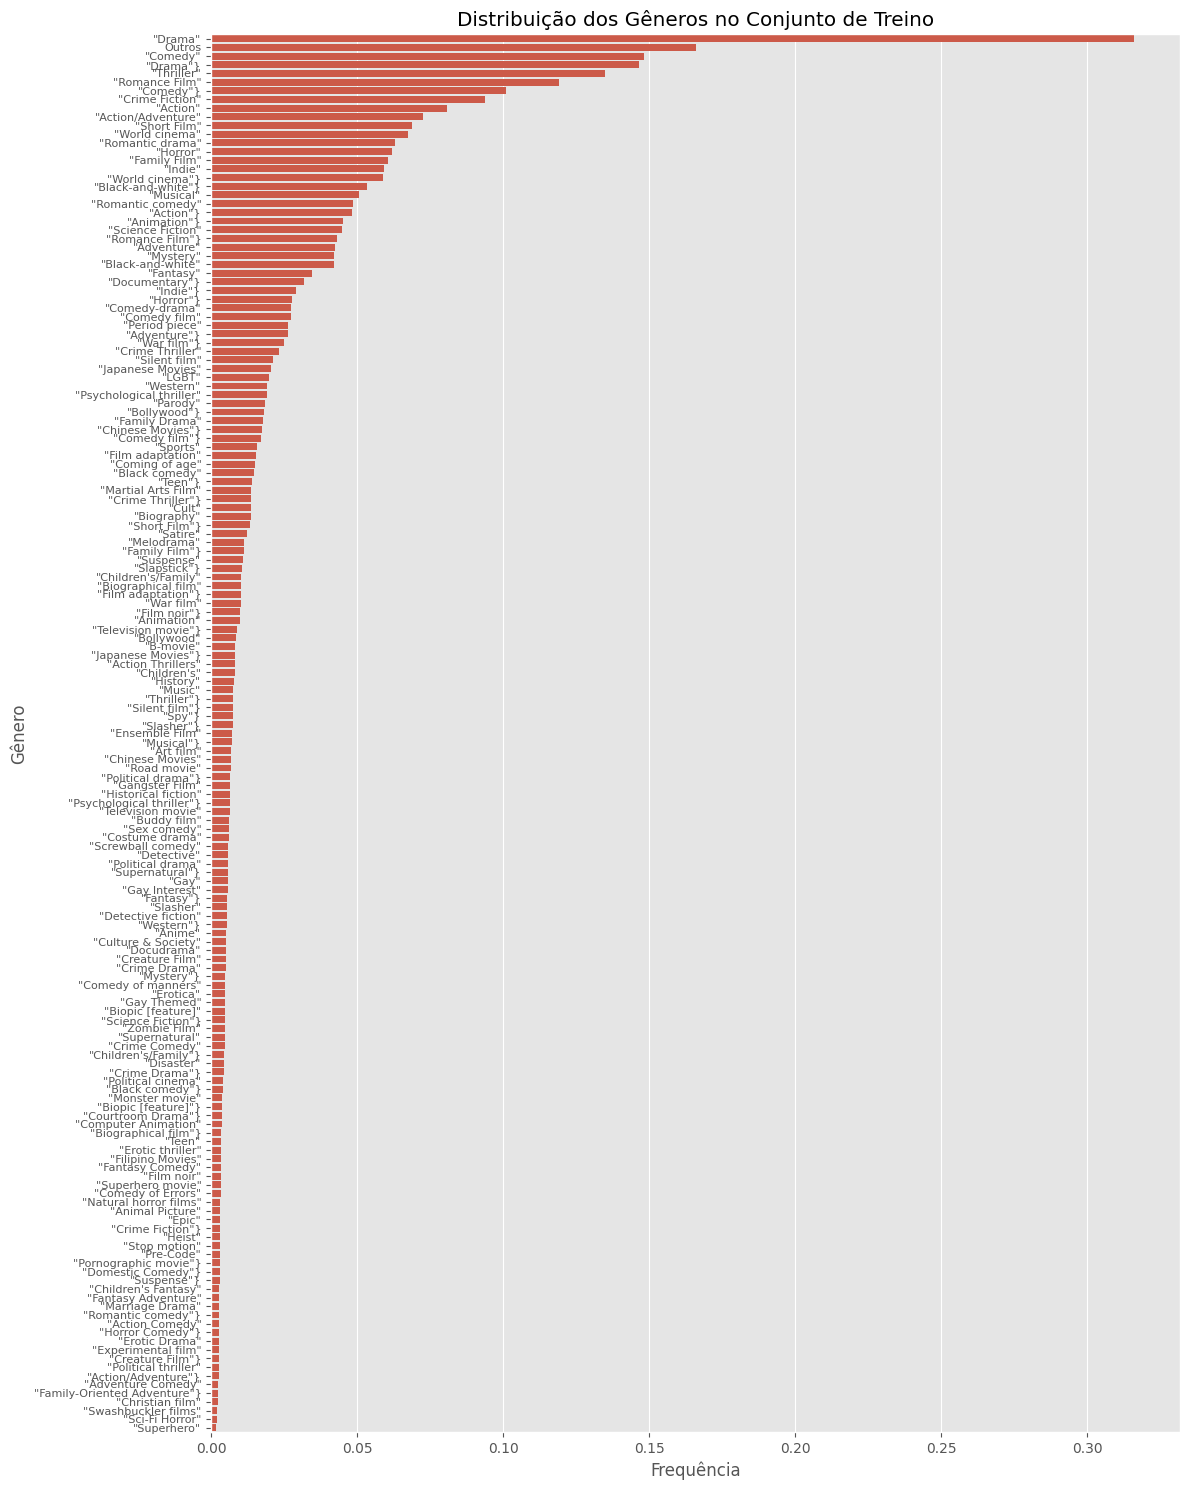

In [32]:
# Distribuição dos gêneros
genre_dist = y_train_bin.sum(axis=0) / len(y_train)
genre_dist_df = pd.DataFrame({'genre': mlb.classes_, 'frequency': genre_dist})
genre_dist_df = genre_dist_df.sort_values('frequency', ascending=False)

plt.figure(figsize=(12, 15))
sns.barplot(x='frequency', y='genre', data=genre_dist_df)
plt.title('Distribuição dos Gêneros no Conjunto de Treino')
plt.xlabel('Frequência')
plt.ylabel('Gênero')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

### 5. Modelagem


#### 5.1 Abordagem com OneVsRestClassifier e TF-IDF

In [33]:
# Pipeline com TF-IDF e OneVsRestClassifier com LinearSVC
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, min_df=3, max_df=0.9)),
    ('clf', OneVsRestClassifier(LinearSVC(C=1.0, class_weight='balanced')))
])

In [34]:
# Treino
pipeline_svc.fit(X_train, y_train_bin)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3)),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced')))])

In [35]:
# Avaliação
y_pred_svc = pipeline_svc.predict(X_test)

In [36]:
print("Métricas de avaliação para LinearSVC:")
print(f"Hamming Loss: {hamming_loss(y_test_bin, y_pred_svc):.4f}")
print(f"Micro F1 Score: {f1_score(y_test_bin, y_pred_svc, average='micro'):.4f}")
print(f"Macro F1 Score: {f1_score(y_test_bin, y_pred_svc, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test_bin, y_pred_svc, average='weighted'):.4f}")

Métricas de avaliação para LinearSVC:
Hamming Loss: 0.0352
Micro F1 Score: 0.3160
Macro F1 Score: 0.1831
Weighted F1 Score: 0.3087


In [37]:
print("\nRelatório de classificação por gênero:")
print(classification_report(y_test_bin, y_pred_svc, target_names=mlb.classes_))


Relatório de classificação por gênero:
                              precision    recall  f1-score   support

             "Action Comedy"       0.00      0.00      0.00        19
          "Action Thrillers"       0.24      0.12      0.16        64
                    "Action"       0.23      0.44      0.30       524
                   "Action"}       0.16      0.30      0.21       337
          "Action/Adventure"       0.31      0.51      0.39       528
         "Action/Adventure"}       0.00      0.00      0.00        19
          "Adventure Comedy"       0.00      0.00      0.00        10
                 "Adventure"       0.21      0.35      0.26       302
                "Adventure"}       0.14      0.23      0.18       172
            "Animal Picture"       0.20      0.12      0.15        17
                 "Animation"       0.13      0.10      0.12        69
                "Animation"}       0.50      0.67      0.57       285
                     "Anime"       0.31      0.16

#### 5.2 Abordagem com Regressão Logística

In [38]:
# Pipeline com TF-IDF e OneVsRestClassifier com Regressão Logística
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, min_df=3, max_df=0.9, ngram_range=(1, 2))), 
    ('clf', OneVsRestClassifier(LogisticRegression(C=5.0, solver='liblinear', class_weight='balanced')))
])

In [39]:
# Treino
pipeline_lr.fit(X_train, y_train_bin)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3,
                                 ngram_range=(1, 2))),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=5.0,
                                                                  class_weight='balanced',
                                                                  solver='liblinear')))])

In [40]:
# Avaliação
y_pred_lr = pipeline_lr.predict(X_test)

In [41]:
print("Métricas de avaliação para Regressão Logística:")
print(f"Hamming Loss: {hamming_loss(y_test_bin, y_pred_lr):.4f}")
print(f"Micro F1 Score: {f1_score(y_test_bin, y_pred_lr, average='micro'):.4f}")
print(f"Macro F1 Score: {f1_score(y_test_bin, y_pred_lr, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test_bin, y_pred_lr, average='weighted'):.4f}")

Métricas de avaliação para Regressão Logística:
Hamming Loss: 0.0376
Micro F1 Score: 0.3337
Macro F1 Score: 0.2163
Weighted F1 Score: 0.3365


#### 5.3 Abordagem com Redes Neurais (LSTM)

In [42]:
max_features = 20000  
maxlen = 500 

In [43]:
# Tokenização de texto
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [44]:
# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

In [45]:
# Construindo o modelo LSTM
model = Sequential([
    Embedding(max_features, 128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_bin.shape[1], activation='sigmoid')
])

In [46]:
# Compilando
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Treinando o modelo
history = model.fit(X_train_pad, y_train_bin, batch_size=32, epochs=10, 
                    validation_split=0.1, verbose=1)

Epoch 1/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 387s 490ms/step - accuracy: 0.0495 - loss: 0.1788 - val_accuracy: 0.0804 - val_loss: 0.0856
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 366s 469ms/step - accuracy: 0.0853 - loss: 0.0904 - val_accuracy: 0.0804 - val_loss: 0.0843
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 381s 488ms/step - accuracy: 0.0862 - loss: 0.0880 - val_accuracy: 0.0804 - val_loss: 0.0837
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 498s 638ms/step - accuracy: 0.0921 - loss: 0.0846 - val_accuracy: 0.0779 - val_loss: 0.0822
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 410s 526ms/step - accuracy: 0.0954 - loss: 0.0820 - val_accuracy: 0.0836 - val_loss: 0.0815
Epoch 6/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 422s 542ms/step - accuracy: 0.1192 - loss: 0.0782 - val_accuracy: 0.0847 - val_loss: 0.0821
Epoch 7/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 421s 539ms/step - accuracy: 0.1359 - loss: 0.0757 - val_accuracy: 0.0898 - val_loss: 0.0823
Epoch 8/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 440s 565ms/step - accuracy: 0.1436 -

In [49]:
# Avaliando o modelo
y_pred_probs = model.predict(X_test_pad)
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
best_micro_f1 = 0
best_threshold = 0
best_y_pred_lstm = None

217/217 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step


In [50]:
for thresh in thresholds:
    y_pred_lstm = (y_pred_probs > thresh).astype(int)
    micro_f1 = f1_score(y_test_bin, y_pred_lstm, average='micro')
    print(f"Threshold {thresh} - Micro F1: {micro_f1:.4f}")
    if micro_f1 > best_micro_f1:
        best_micro_f1 = micro_f1
        best_threshold = thresh
        best_y_pred_lstm = y_pred_lstm

Threshold 0.1 - Micro F1: 0.2411
Threshold 0.2 - Micro F1: 0.2434
Threshold 0.3 - Micro F1: 0.1959
Threshold 0.4 - Micro F1: 0.1381
Threshold 0.5 - Micro F1: 0.0939


In [51]:
print(f"\nMelhor threshold: {best_threshold}")
print("Métricas de avaliação para LSTM:")
print(f"Hamming Loss: {hamming_loss(y_test_bin, y_pred_lstm):.4f}")
print(f"Micro F1 Score: {f1_score(y_test_bin, y_pred_lstm, average='micro'):.4f}")
print(f"Macro F1 Score: {f1_score(y_test_bin, y_pred_lstm, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test_bin, y_pred_lstm, average='weighted'):.4f}")


Melhor threshold: 0.2
Métricas de avaliação para LSTM:
Hamming Loss: 0.0217
Micro F1 Score: 0.0939
Macro F1 Score: 0.0110
Weighted F1 Score: 0.0641


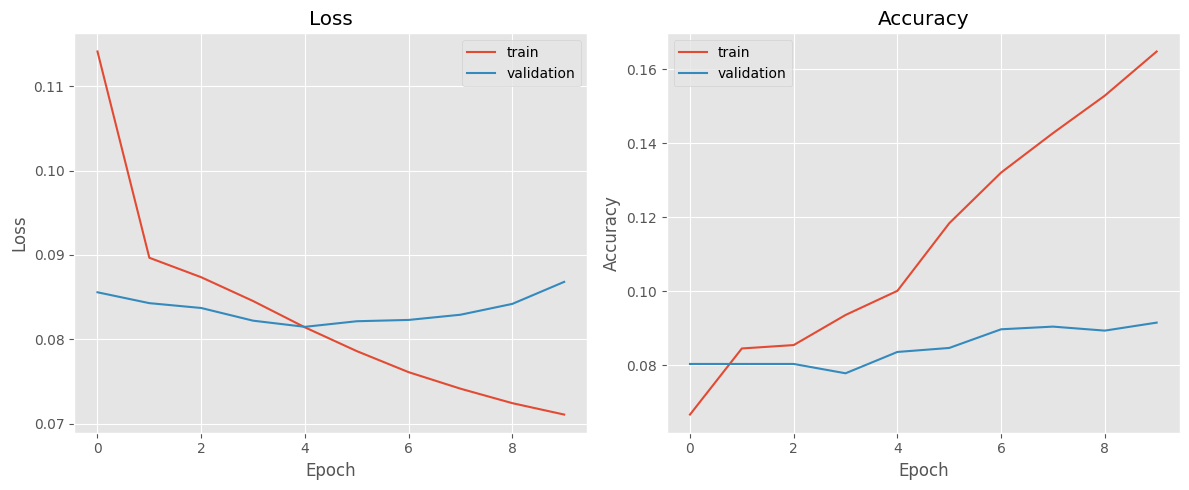

In [52]:
# Plotando a curva de aprendizado
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### 6. Comparação dos Modelos

In [53]:
models = ['LinearSVC', 'Logistic Regression', 'LSTM']
hamming_losses = [
    hamming_loss(y_test_bin, y_pred_svc),
    hamming_loss(y_test_bin, y_pred_lr),
    hamming_loss(y_test_bin, y_pred_lstm)
]
micro_f1 = [
    f1_score(y_test_bin, y_pred_svc, average='micro'),
    f1_score(y_test_bin, y_pred_lr, average='micro'),
    f1_score(y_test_bin, y_pred_lstm, average='micro')
]
macro_f1 = [
    f1_score(y_test_bin, y_pred_svc, average='macro'),
    f1_score(y_test_bin, y_pred_lr, average='macro'),
    f1_score(y_test_bin, y_pred_lstm, average='macro')
]
weighted_f1 = [
    f1_score(y_test_bin, y_pred_svc, average='weighted'),
    f1_score(y_test_bin, y_pred_lr, average='weighted'),
    f1_score(y_test_bin, y_pred_lstm, average='weighted')
]

comparison_df = pd.DataFrame({
    'Model': models,
    'Hamming Loss': hamming_losses,
    'Micro F1': micro_f1,
    'Macro F1': macro_f1,
    'Weighted F1': weighted_f1
})

print(comparison_df)


                 Model  Hamming Loss  Micro F1  Macro F1  Weighted F1
0            LinearSVC      0.035236  0.315991  0.183124     0.308746
1  Logistic Regression      0.037633  0.333735  0.216305     0.336516
2                 LSTM      0.021742  0.093855  0.011030     0.064134


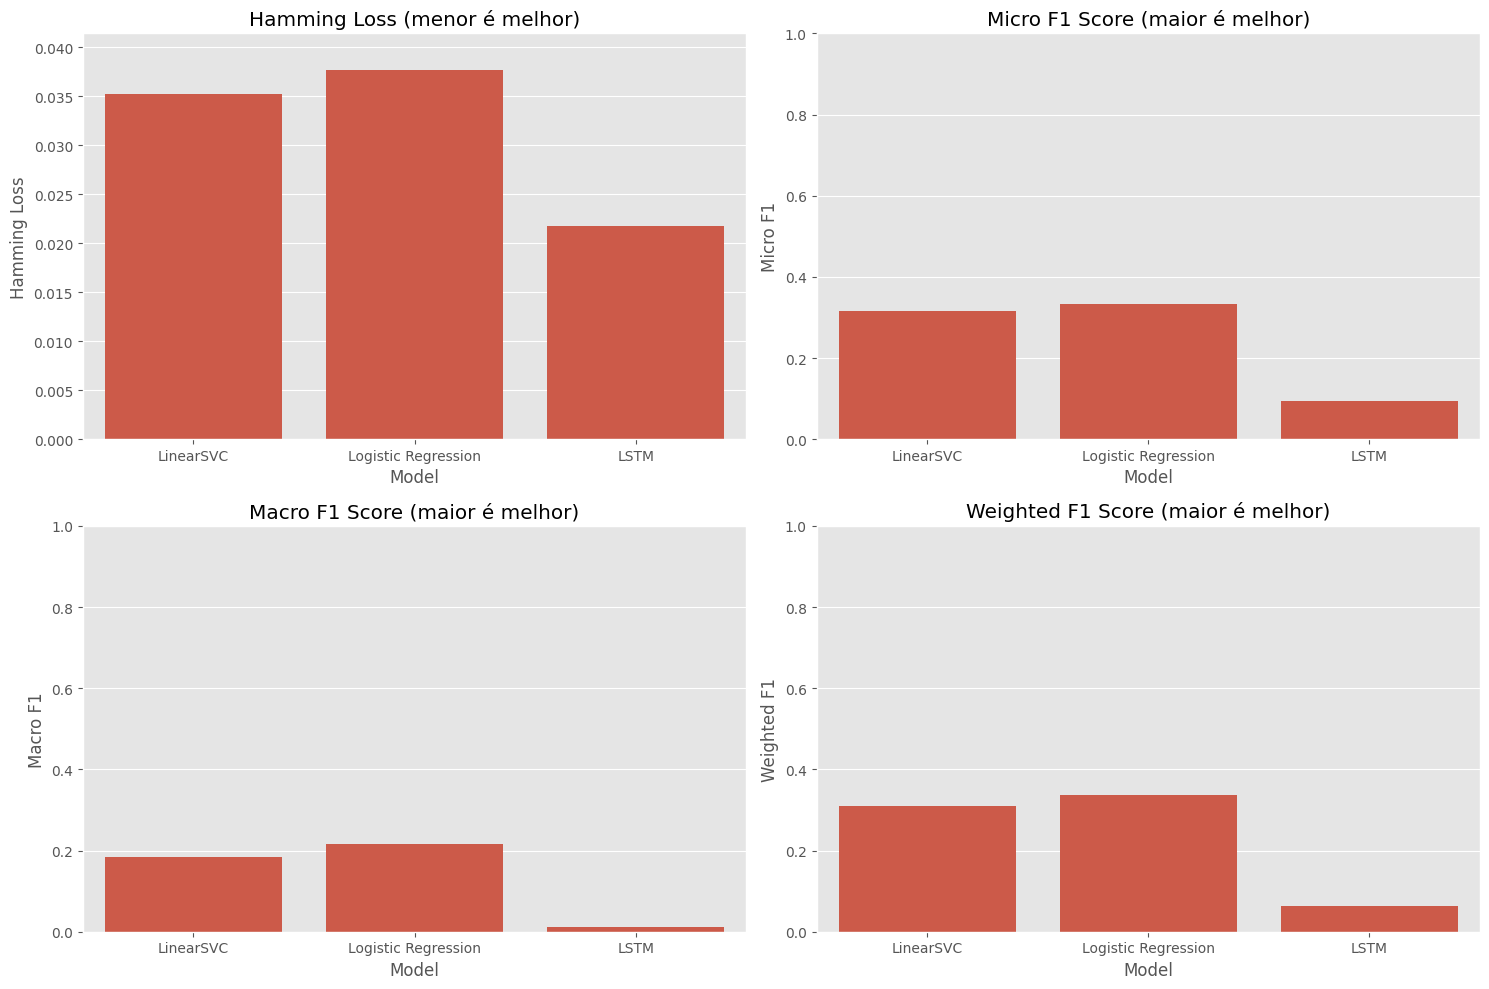

In [54]:
# Visualizando a comparação
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Hamming Loss', data=comparison_df)
plt.title('Hamming Loss (menor é melhor)')
plt.ylim(0, max(hamming_losses) * 1.1)

plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Micro F1', data=comparison_df)
plt.title('Micro F1 Score (maior é melhor)')
plt.ylim(0, 1)

plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Macro F1', data=comparison_df)
plt.title('Macro F1 Score (maior é melhor)')
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Weighted F1', data=comparison_df)
plt.title('Weighted F1 Score (maior é melhor)')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [55]:
# Selecionando o melhor modelo baseado no F1 Score ponderado
best_model_index = comparison_df['Weighted F1'].idxmax()
best_model = models[best_model_index]
print(f"O melhor modelo é: {best_model}")

O melhor modelo é: Logistic Regression


### 7. Pipeline de Predição para Novas Sinopses

In [56]:
# Salvando os componentes necessários para o pipeline de predição
def save_prediction_pipeline(model, vectorizer, mlb):
    with open('../models/model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    with open('../models/vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    
    with open('../models/mlb.pkl', 'wb') as f:
        pickle.dump(mlb, f)

In [57]:
# Extraindo o vetorizador do pipeline e salvando
best_pipeline = pipeline_lr 
tfidf_vectorizer = best_pipeline.named_steps['tfidf']
classifier = best_pipeline.named_steps['clf']

In [58]:
save_prediction_pipeline(classifier, tfidf_vectorizer, mlb)

In [59]:
# Função para fazer predições em novas sinopses
def predict_genres(synopsis, vectorizer, classifier, mlb, preprocess=True):
    if preprocess:
        synopsis = preprocess_text(synopsis)
    
    synopsis_vec = vectorizer.transform([synopsis])
    genres_bin = classifier.predict(synopsis_vec)
    
    genres = mlb.inverse_transform(genres_bin)[0]
    return list(genres)

In [60]:
# Testando o pipeline de predição com algumas sinopses do conjunto de teste
test_samples = X_test.sample(10).tolist()
for i, synopsis in enumerate(test_samples, 1):
    predicted_genres = predict_genres(synopsis, tfidf_vectorizer, classifier, mlb)
    print(f"\nSinopse de teste {i} (primeiros 200 caracteres):")
    print(f"{synopsis[:200]}...")
    print(f"Gêneros preditos: {predicted_genres}")


Sinopse de teste 1 (primeiros 200 caracteres):
Decade nan: london concert pianist daubenny desire beautiful stella raff stella agree marry bring back large pearl hand thursday island daubenny travel island buy house villainous mendoza also befrien...
Gêneros preditos: ['"Action"', '"Adventure"}', '"Drama"', '"Fantasy"', '"Romantic drama"']

Sinopse de teste 2 (primeiros 200 caracteres):
Decade nan: film set small village ina district nagano prefecture japan hanji young boy see performance kabuki first time dedication event village fascinate performance yukio character young hanji dan...
Gêneros preditos: ['"Drama"', '"Drama"}', '"Historical fiction"', '"Japanese Movies"', '"World cinema"', 'Outros']

Sinopse de teste 3 (primeiros 200 caracteres):
Decade nan: thamizh lead happy life mother manorama sisterinlaw work kuwait thamizh dream join meenakshi simran tenant thamizh fall love goon periyavar injure niece stop periyavar car road question be...
Gêneros preditos: ['"Action"', '"Drama